The AI agent for this project is a weather predictor. This weather predcitor is a utility-based agent, which can be explained in terms of PEAS (Performance measure, Environment, Actuators, Sensors).
- The performance measure for this agent is to accurately predict the weather (e.g. whether it's raining or not) while minimizing the incorrect classifications. 
- The environment for this agent is the dataset that includees Seattle's weather conditions from the year 2012 to the year 2015, as well as the real-world environment which includes precipitation, temperature fluctuatoins, and season effects. 
- The actuators for this agent are the output predictions about the weather based on the input conditions.
- The sensors for this agent are the inputs from previous weather data: preciptation, temperature, wind, and speed

The weather prediction agent is built using a Naive Bayes Classifier, which is a probablistic model that estimates the likelihood of different weather conditions based on the given features. 

In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

Data Exploration and Preprocessing

In [ ]:
# Load the dataset
file_path = "seattle-weather.csv"  
df = pd.read_csv(file_path)

In [ ]:
# Check basic information
print("Dataset Overview:")
print(df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None


In this dataset, there are 1461 observations.

Column Descriptions:

- date: the specific date of the observation, in a YYYY-MM-DD format
- preciptation: the total rainfall or snowfall received during the day (millimeters)
- temp_max: maximum temperature recorded that day (Degrees Celsius)
- temp_min: minimum temperature recorded on that day 
- wind: average daily wind speed (meters per second)
- weather: represents weather conditions of that day (e.g. rain, sun, drizzle, fog, snow)

In [ ]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


Thankfully, there is no data missing, so no adjustments need there. 

In [ ]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Encode the categorical 'weather' column
label_encoder = LabelEncoder()
df['weather_encoded'] = label_encoder.fit_transform(df['weather'])

In [ ]:
# Scale numerical features
scaler = MinMaxScaler()
df[['precipitation', 'temp_max', 'temp_min', 'wind']] = scaler.fit_transform(df[['precipitation', 'temp_max', 'temp_min', 'wind']])

In [ ]:
# Display summary statistics after preprocessing
print("\nSummary Statistics After Scaling:\n", df.describe())


Summary Statistics After Scaling:
                       date  precipitation     temp_max     temp_min  \
count                 1461    1461.000000  1461.000000  1461.000000   
mean   2013-12-31 00:00:00       0.054194     0.484922     0.603731   
min    2012-01-01 00:00:00       0.000000     0.000000     0.000000   
25%    2012-12-31 00:00:00       0.000000     0.327957     0.452756   
50%    2013-12-31 00:00:00       0.000000     0.462366     0.606299   
75%    2014-12-31 00:00:00       0.050089     0.639785     0.759843   
max    2015-12-31 00:00:00       1.000000     1.000000     1.000000   
std                    NaN       0.119503     0.197574     0.197756   

              wind  weather_encoded  
count  1461.000000      1461.000000  
mean      0.312213         2.752225  
min       0.000000         0.000000  
25%       0.197802         2.000000  
50%       0.285714         2.000000  
75%       0.395604         4.000000  
max       1.000000         4.000000  
std       0.158003  

<Figure size 1200x600 with 0 Axes>

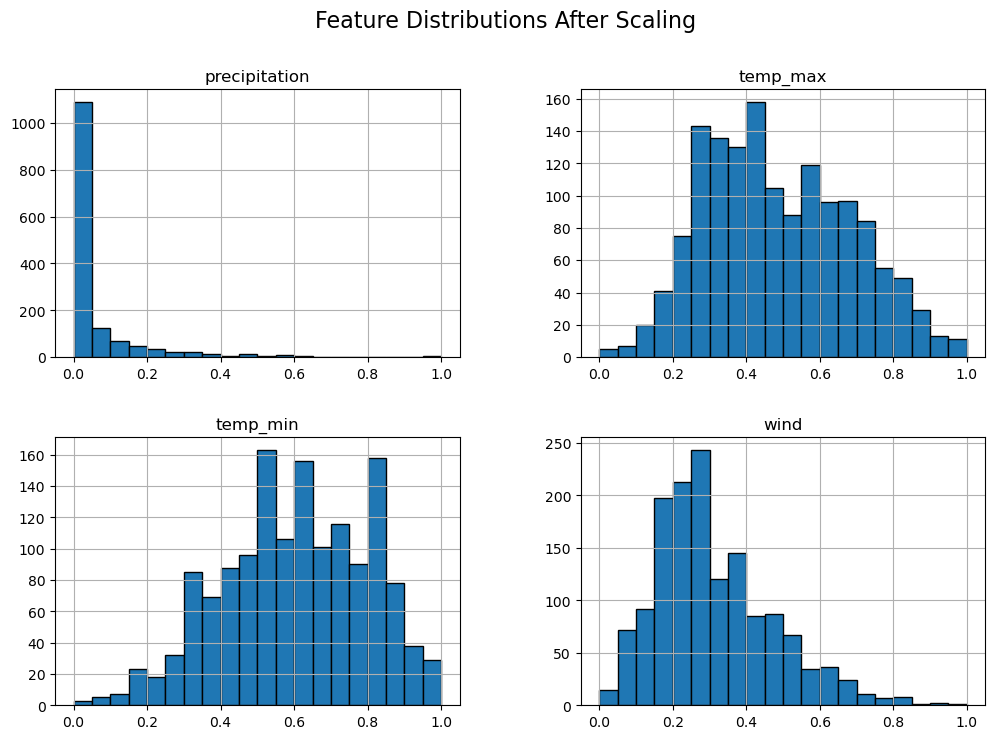

In [ ]:
# Plot feature distributions
plt.figure(figsize=(12, 6))
df[['precipitation', 'temp_max', 'temp_min', 'wind']].hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Feature Distributions After Scaling", fontsize=16)
plt.show()

In [ ]:
# Display the first few rows of the cleaned dataset
print("\nProcessed Dataset Sample:\n", df.head())


Processed Dataset Sample:
         date  precipitation  temp_max  temp_min      wind  weather  \
0 2012-01-01       0.000000  0.387097  0.476378  0.472527  drizzle   
1 2012-01-02       0.194991  0.327957  0.389764  0.450549     rain   
2 2012-01-03       0.014311  0.357527  0.562992  0.208791     rain   
3 2012-01-04       0.363148  0.370968  0.500000  0.472527     rain   
4 2012-01-05       0.023256  0.282258  0.389764  0.626374     rain   

   weather_encoded  
0                0  
1                2  
2                2  
3                2  
4                2  


Converting observatinos into probabilities and generating the CPTs

In [48]:
# Encode categorical 'weather' column
weather_types = df['weather'].unique()
weather_counts = df['weather'].value_counts(normalize=True)  # Prior probabilities P(Weather)

In [49]:
# Compute Likelihood Probabilities P(Feature | Weather) using Gaussian distributions
feature_columns = ['precipitation', 'temp_max', 'temp_min', 'wind']
likelihoods = {}

for weather in weather_types:
    subset = df[df['weather'] == weather]
    likelihoods[weather] = {}
    for feature in feature_columns:
        mean = subset[feature].mean()
        std = subset[feature].std()
        likelihoods[weather][feature] = (mean, std)  # Store mean and std for Gaussian distribution

In [50]:
# Create a Conditional Probability Table (CPT)
cpt_data = []
for weather, probs in likelihoods.items():
    row = [weather, weather_counts[weather]]
    for feature in feature_columns:
        mean, std = probs[feature]
        row.extend([mean, std])
    cpt_data.append(row)

In [51]:
# Construct DataFrame for CPT
columns = ['Weather', 'P(Weather)']
for feature in feature_columns:
    columns.extend([f'P({feature} | Weather)_Mean', f'P({feature} | Weather)_Std'])

cpt_df = pd.DataFrame(cpt_data, columns=columns)


In [53]:
# Return prior probabilities and CPT summary
weather_counts, cpt_df.head()

(weather
 rain       0.438741
 sun        0.438056
 fog        0.069131
 drizzle    0.036277
 snow       0.017796
 Name: proportion, dtype: float64,
    Weather  P(Weather)  P(precipitation | Weather)_Mean  \
 0  drizzle    0.036277                         0.000000   
 1     rain    0.438741                         0.117314   
 2      sun    0.438056                         0.000000   
 3     snow    0.017796                         0.153021   
 4      fog    0.069131                         0.000000   
 
    P(precipitation | Weather)_Std  P(temp_max | Weather)_Mean  \
 0                        0.000000                    0.471140   
 1                        0.154697                    0.404694   
 2                        0.000000                    0.576932   
 3                        0.125609                    0.192825   
 4                        0.000000                    0.493479   
 
    P(temp_max | Weather)_Std  P(temp_min | Weather)_Mean  \
 0                   0.236883 

Training and evaluating the first model

In [39]:
# Define features and target variable
X = df[['precipitation', 'temp_max', 'temp_min', 'wind']]  # Features
y = df['weather_encoded']  # Target (weather condition)

In [40]:
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Train a Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [42]:
# Make predictions
y_pred = nb_model.predict(X_test)

In [43]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

In [44]:
# Display results
print(f"Model Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Model Accuracy: 82.94%

Classification Report:
               precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         9
         fog       1.00      0.00      0.00        25
        rain       0.96      0.91      0.94       120
        snow       0.57      0.50      0.53         8
         sun       0.76      0.99      0.86       131

    accuracy                           0.83       293
   macro avg       0.66      0.48      0.47       293
weighted avg       0.84      0.83      0.78       293

Confusion Matrix:
 [[  0   0   0   0   9]
 [  1   0   0   0  24]
 [  0   0 109   3   8]
 [  0   0   4   4   0]
 [  1   0   0   0 130]]


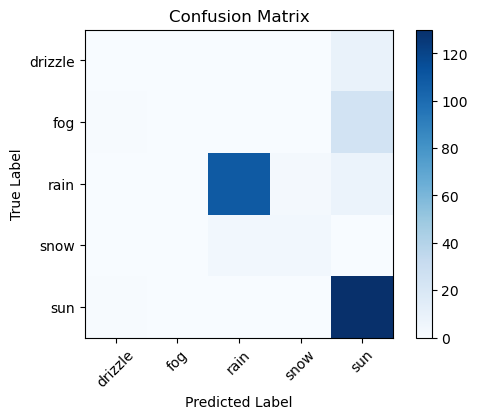

In [45]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
plt.show()

Conclusion

Although the model accuracy is high (82.94%), there is zero precision and recall for some cases. This is due to the severe class imbalance, as the weather types drizzle, fog, and snow have very few examples in the test set compared to the weather types sun and rain. In order to improve it, the class weights need to be taken into consideration.  